# Objectifs 

Ce carnet est le prolongement du travail sur les fitlres basiques en traitement d'image.
<br>
<br>Nous cherchons ici à mettre en oeuvre un filtre avancé permettant de reproduire l'effet **Bokeh** en photographie.
<br>
<br>Pour des raisons de simplicité :
* Nous nous limiterons aux implémentations qui reposent sur des noyaux de convolution dit "non-séparables". 
* Nous utiliserons des librairies standard pour les opérations de convolution et de pré-traitement.

## Remarque

Il existe en effet des implémentations avec avec des noyaux qui peuvent être décomposés, néanmoins celles-ci sont nettement plus complexe (série de Fourier, opérations sur l'ensemble des nombres complexes, etc...).

## Sources

Pour une description plus détaillée de cet effet, se référer à cet article de blog : <a href="https://lesdeuxpiedsdehors.com/en/bokeh-photography-background-blur/">Les deux pieds dehors</a>.
<br>
<br>Pour plus d'informations concernant l'approche avec un noyau "séparable", se référer aux travaux suivants :
<br>\- [Mike Pound] <a href="https://github.com/mikepound/convolve">GitHub</a> & <a href="https://www.youtube.com/watch?v=vNG3ZAd8wCc">Youtube</a>.
<br>\- [Olli Niemitalo] <a href="http://yehar.com/blog/?p=1495">Blog</a>.

# Préliminaires

Commandes utiles pour l'ensemble des parties qui suivent et qui pourront être appelées à plusieurs reprises :
* Chargement des librairies.
* Chargement des données de test.

## Modules

Les librairies suivantes seront très utiles:
* **Ipyplot**, pour l'affichage d'un ensemble d'images.
* **PIL**, pour le chargement, le pré-traitement et le post-traitement des images.
* **Scikit-Image**, pour la génération de noyaux de convolution personnalisés et la compression Gamma.
* **SciPy**, pour les convolutions de manière très performante.

In [1]:
# Chargement des librairies de bases
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
# Chargement des librairies avancées
import ipyplot
from scipy import ndimage
from PIL import Image,ImageFilter,ImageEnhance
from skimage.draw import disk, polygon
from skimage import exposure

In [3]:
# Configuration basique
%matplotlib inline
plt.style.use('seaborn-whitegrid')

## Données

In [4]:
# Lien vers les images
christmas0_filepath = "./images/christmas0.ppm"
christmas1_filepath = "./images/christmas1.jpg"
christmas2_filepath = "./images/christmas2.jpg"
christmas3_filepath = "./images/christmas3.jpg"

In [5]:
# Lien vers les noyaux de convolution
circle_large_filepath = "./images/circle.ppm"
hexagon_large_filepath = "./images/hexagon.ppm"
heart_large_filepath = "./images/heart.ppm"
star_large_filepath = "./images/star.ppm"
circle_filepath = "./images/circle.png"
hexagon_filepath = "./images/hexagon.png"
heart_filepath = "./images/heart.png"
star_filepath = "./images/star.png"

In [6]:
# Chargement des images
christmas0_img = Image.open(christmas0_filepath)
christmas1_img = Image.open(christmas1_filepath)
christmas2_img = Image.open(christmas2_filepath)
christmas3_img = Image.open(christmas3_filepath)


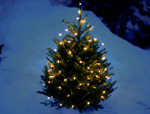
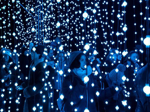
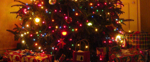
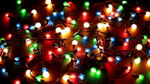


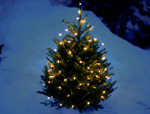
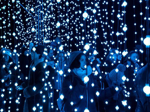
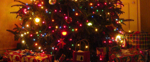
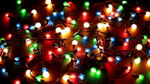

In [7]:
# Visualisation des images
ipyplot.plot_images(images=[christmas0_img,christmas1_img,
                            christmas2_img,christmas3_img],
                    labels=['christmas0','christmas1',
                            'christmas2','christmas3'],
                    img_width=150)

In [8]:
# Chargement des noyaux
circle_large_img = Image.open(circle_large_filepath)
hexagon_large_img = Image.open(hexagon_large_filepath) 
heart_large_img = Image.open(heart_large_filepath) 
star_large_img = Image.open(star_large_filepath) 
circle_clean_img = Image.open(circle_filepath)
hexagon_clean_img = Image.open(hexagon_filepath) 
heart_clean_img = Image.open(heart_filepath) 
star_clean_img = Image.open(star_filepath) 

In [9]:
# Recadrage des images

# h x w  = (304,400), box = (left, upper, right, lower)
circle_large_img = circle_large_img.crop((0,284, 18, 302)) 
hexagon_large_img = hexagon_large_img.crop((0,289, 17, 304))
heart_large_img = heart_large_img.crop((0,284, 15, 300))
star_large_img = star_large_img.crop((0,282, 21, 302))

# remastered images
kernel_size = (20,20)
circle_img = circle_clean_img.resize(kernel_size)
hexagon_img = hexagon_clean_img.resize(kernel_size)
heart_img = heart_clean_img.resize(kernel_size)
star_img = star_clean_img.resize(kernel_size)

Haute résolution:



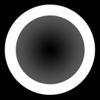
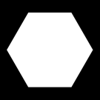
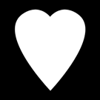
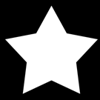


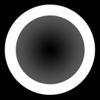
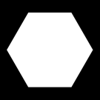
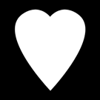
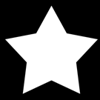

Basse résolution



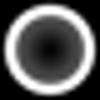
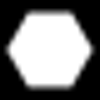
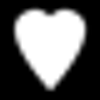
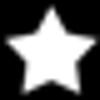


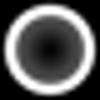
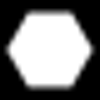
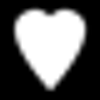
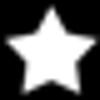

In [10]:
# Visualisation des noyaux
print("Haute résolution:")
ipyplot.plot_images(images=[circle_clean_img,hexagon_clean_img,
                            heart_clean_img,star_clean_img],
                    labels=['circle','hexagon','heart','star'],
                    img_width=100)
print("Basse résolution")
ipyplot.plot_images(images=[circle_img,hexagon_img,heart_img,star_img],
                    labels=['circle','hexagon','heart','star'],
                    img_width=100)

## Fonctions

Définition des fonctions suivantes :
* **create_disk_ker()**, génère un tableau avec une "forme" de disque. 
* **create_star_ker()**, génère un tableau avec une "forme" de triangle.

In [11]:
def create_disk_ker(R,border=1,normalize=False,uint8=False):
    D = 2*R+border

    if uint8:
        disk_np = np.zeros((D,D)).astype(dtype=np.uint8)
    else:
        disk_np = np.zeros((D,D))  
        
    rr, cc = disk((D//2, D//2), R, shape=(D,D))
    disk_np[rr,cc] = 1
    
    if normalize:
        disk_np = disk_np/np.sum(disk_np)
    
    return disk_np

In [12]:
def create_star_ker(N,border=1,flip=False,normalize=False,uint8=False):
   
    if uint8:
        star_np = np.zeros((N,N)).astype(dtype=np.uint8)
    else:
        star_np = np.zeros((N,N)) 
    
    r = np.array([border, border, N-border-1])
    c = np.array([border, N-border-1, N//2])
    rr, cc = polygon(r, c)
    star_np[rr, cc] = 1
    
    if flip:
        star_np = np.flipud(star_np)

    return star_np

Exemples :

In [13]:
# Visualisation d'un noyau en forme de disque
print(create_disk_ker(5,normalize=False,uint8=True))

[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


In [14]:
# Visualisation d'un noyau en forme de triangle
print((create_star_ker(9,1,True)))

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Comparaison entre l'effet Bokeh et le fou Gaussien

Nous mettons en avant sur plusieurs exemples la ressemblance entre l'effet Bokeh et le flou en arrière-plan d'une photo, là où le flou Gaussien semble beaucoup plus "homogène" est synthétique.

In [15]:
def compare_bokeh_gaussian(image,kernel,sigma):
    # Inputs
    input_np = np.array(image)
    ker_img = Image.fromarray((kernel*255.0/np.max(kernel)).astype('uint8'))

    # Convolve
    bokeh_np = np.zeros(input_np.shape,dtype=np.uint8)
    for i in range(3):
        bokeh_np[:,:,i] = ndimage.convolve(input_np[:,:,i], kernel)

    # Control
    gaussian_np = np.zeros(input_np.shape,dtype=np.uint8)
    for i in range(3):
        gaussian_np[:,:,i] = ndimage.gaussian_filter(input_np[:,:,i], sigma=sigma)

    # Convert back to PIL image
    bokeh_img = Image.fromarray(bokeh_np)
    gaussian_img = Image.fromarray(gaussian_np)

    ipyplot.plot_images(images=[ker_img,image,bokeh_img,gaussian_img],
                        labels=['kernel','original','bokeh','gaussian'],
                        img_width=150)


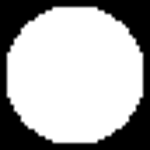
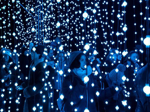
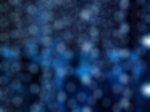
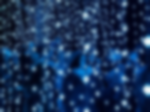


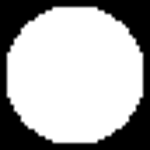
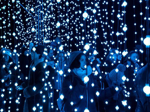
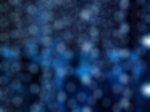
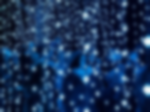


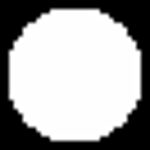
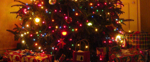
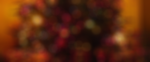
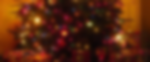


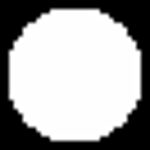
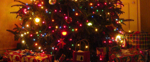
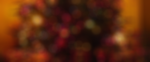
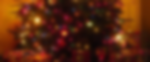


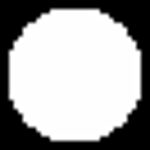
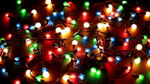
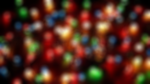
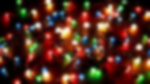


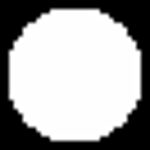
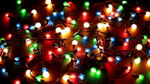
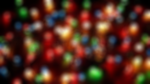
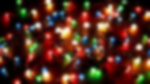

In [16]:
# Validation du concept sur plusieurs exemples
ker_disk1_np = create_disk_ker(20,border=3,normalize=True,uint8=True)
ker_disk2_np = create_disk_ker(15,border=3,normalize=True,uint8=True)
ker_disk3_np = create_disk_ker(15,border=3,normalize=True,uint8=True)
compare_bokeh_gaussian(christmas1_img,ker_disk1_np,8)
compare_bokeh_gaussian(christmas2_img,ker_disk2_np,6)
compare_bokeh_gaussian(christmas3_img,ker_disk3_np,6)

# Impact de la forme du noyau

La forme du noyau de convolution a un impact sur l'effet Bokeh. Modifier le noyau de convolution équivaut à mettre en place un obturateur sur son appareil photo numérique.

**Remarque**
<br>\- Les noyaux sont convertis en niveau de gris.
<br>\- L'image d'entrée et le noyau de convolution sont pré-traitées pour accentuer l'effet Bokeh (accentuation de la "luminosité" sur les zones les plus lumineuses).
<br>\- L'image de sortie est post-traitée pour améliorer le rendu (utilisation du module PIL.ImageEnhance)


**Source**
<br>Ce travail est largement inspiré de l'article de Blog suivant : <a href="https://www.scratchapixel.com/lessons/digital-imaging/simple-image-manipulations/bookeh-effect">Scratchapixel2.0</a>.


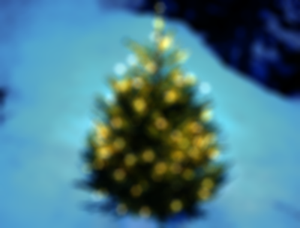
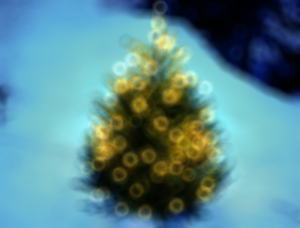
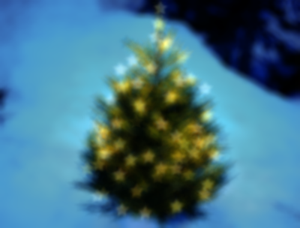
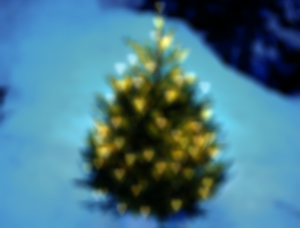


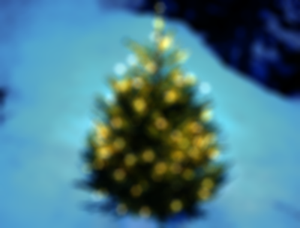
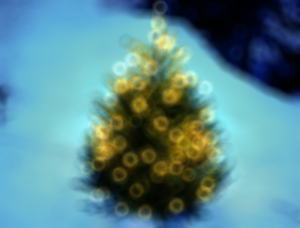
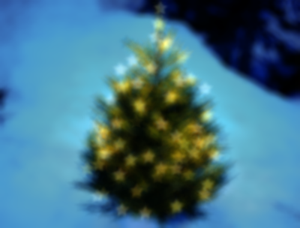
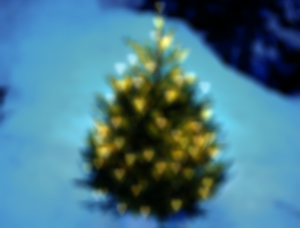

In [17]:
# Impact du choix de la forme du noyau sur le résultat

# Convert image to array (kernel is greyscale)
kernels = [np.array(hexagon_img.convert('L')),np.array(circle_img.convert('L')),
           np.array(star_img.convert('L')),np.array(heart_img.convert('L'))]
christmas0_np = np.array(christmas0_img)

# Magnify
kernels = [np.where(kernel < 0.7,0.3*kernel,3.0*kernel) for kernel in kernels]
christmas0_np = np.where(christmas0_np < 0.7,0.3*christmas0_np,3.0*christmas0_np)

# Convolve
bokeh_images = []
for kernel in kernels:
    out_np = np.zeros(christmas0_np.shape)
    for i in range(3):
        out_np[:,:,i] = ndimage.convolve(christmas0_np[:,:,i],kernel)
        out_np[:,:,i] = out_np[:,:,i]*255/np.max(out_np[:,:,i])
    out_img = Image.fromarray(out_np.astype('uint8'))
    bokeh_images.append(out_img)

# Effect
contrast_factor = 1.2
colorful_factor = 1.5
brightness_factor = 0.8
for bokeh_img in bokeh_images:

    contrast = ImageEnhance.Contrast(bokeh_img)
    bokeh_img = contrast.enhance(contrast_factor)

    colorful = ImageEnhance.Color(bokeh_img)
    bokeh_img = colorful.enhance(colorful_factor)

    enhancer = ImageEnhance.Brightness(bokeh_img)
    bokeh_img = enhancer.enhance(brightness_factor)

# Display
labels = ['hexagon','circle','star','heart']
ipyplot.plot_images(images=bokeh_images, labels=labels, img_width=300)

# Parenthèse sur la compression

L'oeil humain est beaucoup plus sensible aux variations de luminosité pour pour de faibles intensités.
<br>Pour s'adapter à cette particularité, il convient de concenter les valeurs pour les faibles intensités.
<br><img src="./schémas/gamma.png" style="width: 350px"/>

**Sources**
<br>Pour plus d'informations à ce sujet, se référer à :
<br>\- Ce cours <a href="https://e2eml.school/convert_rgb_to_grayscale.html">e2eML School</a>.
<br>\- Cet article <a href = "https://theailearner.com/2019/01/26/power-law-gamma-transformations/">TheAILearner</a>.
<br>\- Cet exemple sur la librairie <a href="https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_log_gamma.html">scikit-image</a>.


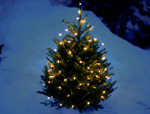
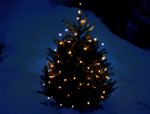
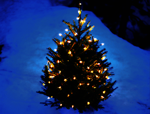
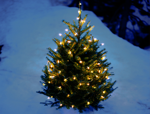


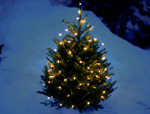
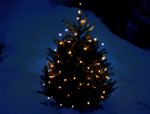
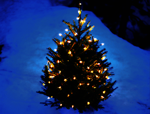
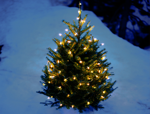

In [18]:
# Visualisation des fonctions de compression de base
# Convert to array
original_np = np.array(christmas0_img)

# Gamma
gamma_corrected_np = exposure.adjust_gamma(original_np, 2)

# Sigmoid
sigmoid_corrected_np = exposure.adjust_sigmoid(original_np,0.5)

# Logarithmic
logarithmic_corrected_np = exposure.adjust_log(original_np, 1)

gamma_corrected_img = Image.fromarray(gamma_corrected_np)
sigmoid_corrected_img = Image.fromarray(sigmoid_corrected_np)
logarithmic_corrected_img = Image.fromarray(logarithmic_corrected_np)

ipyplot.plot_images(images=[christmas0_img,
                            gamma_corrected_img,
                            sigmoid_corrected_img,
                            logarithmic_corrected_img],
                   labels=['original','gamma','sigmoid','logarithmic'])

Les résultats sont beaucoup plus proches de l'attendu après application de la Sigmoïde :


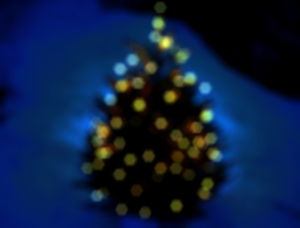
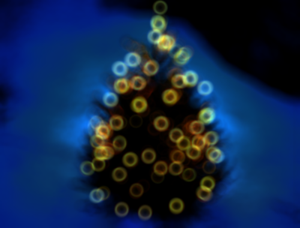
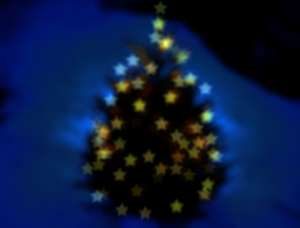
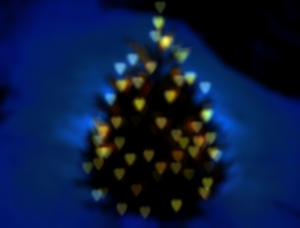


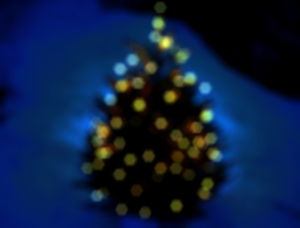
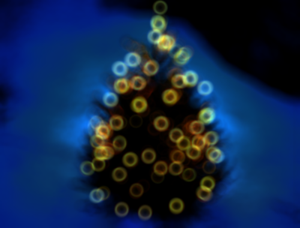
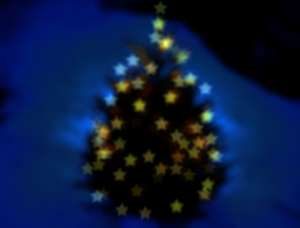
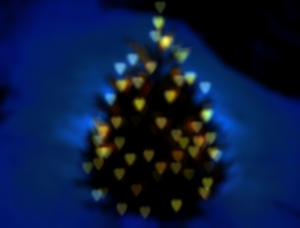

In [19]:
# Impact du choix de la forme du noyau sur le résultat (sigmoid, cutoff=0.7)

# Convert image to array (kernel is greyscale)
kernels = [np.array(hexagon_img.convert('L')),np.array(circle_img.convert('L')),
           np.array(star_img.convert('L')),np.array(heart_img.convert('L'))]
christmas0_np = np.array(christmas0_img)

# Magnify
christmas0_np = exposure.adjust_sigmoid(christmas0_np,0.7)

# Convolve
bokeh_images = []
for kernel in kernels:
    out_np = np.zeros(christmas0_np.shape)
    for i in range(3):
        out_np[:,:,i] = ndimage.convolve(christmas0_np[:,:,i].astype('float'),
                                         kernel.astype('float'))
        out_np[:,:,i] = out_np[:,:,i]*255/np.max(out_np[:,:,i])
    out_img = Image.fromarray(out_np.astype('uint8'))
    bokeh_images.append(out_img)
    
# Display
labels = ['hexagon','circle','star','heart']
ipyplot.plot_images(images=bokeh_images, labels=labels, img_width=300)